# Analyze Region 11 - Central Europe

This notebook analyzes the largest glaciers in Region 11 - Central Europe

In [1]:
import os
import os.path as op
import glob
import sys
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import fiona
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws
import scripts.find_overlapping_entities as foe

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "11"
region_name = "Central Europe"

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 10
region_index_2 = 11

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

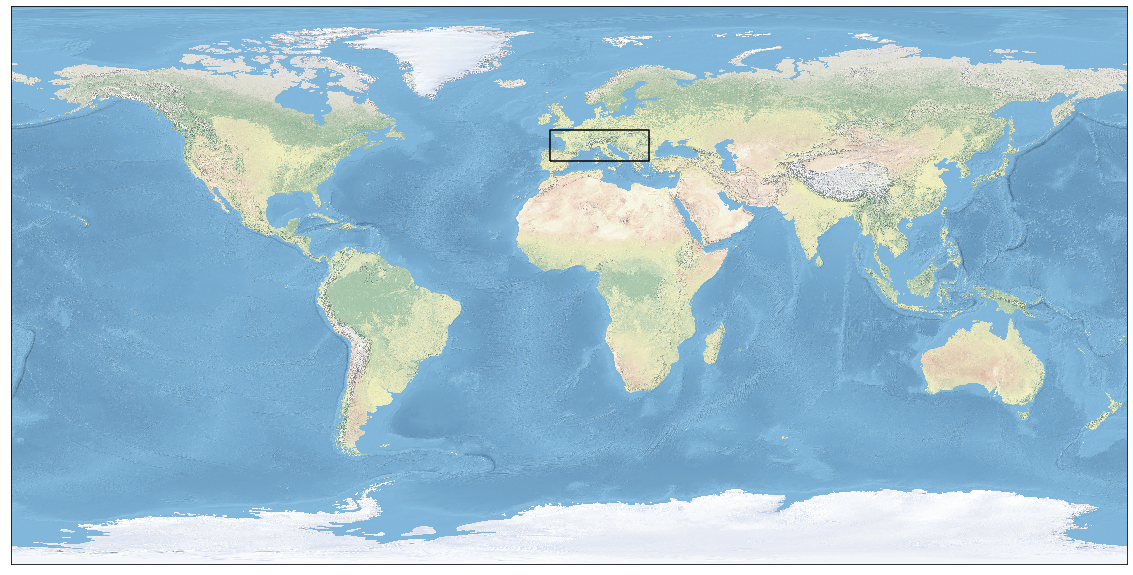

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

,minx,miny,maxx,maxy
10,-6.0,40.0,26.0,50.0


# * * * * * * * * Glacier Analysis * * * * * * * *

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

,region_no,glac_id,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,glac_name,geometry
0,11,G008032E46504N,78.3819,78.3518,0.0,23576.0,0.0,1649.0,3060.0,4126.0,2009-09-15T00:00:00,GROSSER ALETSCH GLETSCHER,"POLYGON Z ((8.018387000000001 46.562885 0, 8.0..."
1,11,G007800E45965N,40.2356,40.2306,0.0,13431.0,0.0,2173.0,3335.0,4576.0,2009-09-15T00:00:00,GORNERGLETSCHER,"POLYGON Z ((7.877975 45.973549 0, 7.878131 45...."
2,11,G008144E46504N,29.4806,29.4750,0.0,15380.0,0.0,1706.0,3110.0,4084.0,2009-09-15T00:00:00,FIESCHERGLETSCHER VS,"POLYGON Z ((8.078189 46.554764 0, 8.0782120000..."
3,11,G008187E46569N,22.5094,22.5060,0.0,12621.0,0.0,1930.0,2692.0,3967.0,2009-09-15T00:00:00,UNTERAARGLETSCHER,"POLYGON Z ((8.139977999999999 46.610912 0, 8.1..."
4,11,G007964E46423N,17.4731,17.4801,0.0,9157.0,0.0,2169.0,2928.0,3811.0,2009-09-15T00:00:00,OBERALETSCH GLETSCHER,"POLYGON Z ((7.973822 46.468593 0, 7.973682 46...."
5,11,G007964E46423N,17.4731,17.4801,0.0,9157.0,0.0,2169.0,2928.0,3811.0,2009-09-15T00:00:00,OBERALETSCH GLETSCHER,"POLYGON Z ((8.004360999999999 46.44558 0, 8.00..."


## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

RGI glacier 0 equals none
RGI glacier 1 equals none
RGI glacier 2 equals none
RGI glacier 4 equals none


In [12]:
rgi_glaciers_df

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-11.01450,G008019E46503N,20030799,20030999,8.01919,46.5028,11,1,82.206,1607,...,149,23746,0,0,0,0,9,9,NONE,"POLYGON ((8.026477001000046 46.56196906400004,..."
1,RGI60-11.02822,G007803E45950N,20030799,20030999,7.80309,45.9502,11,1,56.464,2207,...,325,13618,0,0,0,0,9,9,NONE,"POLYGON ((7.871033715000067 45.94809386300005,..."
2,RGI60-11.01478,G008121E46517N,20030799,20030999,8.12141,46.5169,11,1,31.334,1713,...,138,15373,0,0,0,0,9,9,NONE,"POLYGON ((8.075769852000064 46.55552932600006,..."
3,RGI60-11.03643,G006934E45883N,20030813,-9999999,6.93400,45.8830,11,1,24.179,1529,...,30,13228,0,0,0,0,9,1,FR4N01236A01 Mer de Glace/Geant,"POLYGON ((6.940975000000037 45.91768600000006,..."
4,RGI60-11.01328,G008219E46564N,20030799,20030999,8.21930,46.5642,11,1,23.825,1944,...,84,12635,0,0,0,0,9,9,NONE,"POLYGON ((8.171178630000043 46.53165119900007,..."


## Plot GLIMS Glaciers

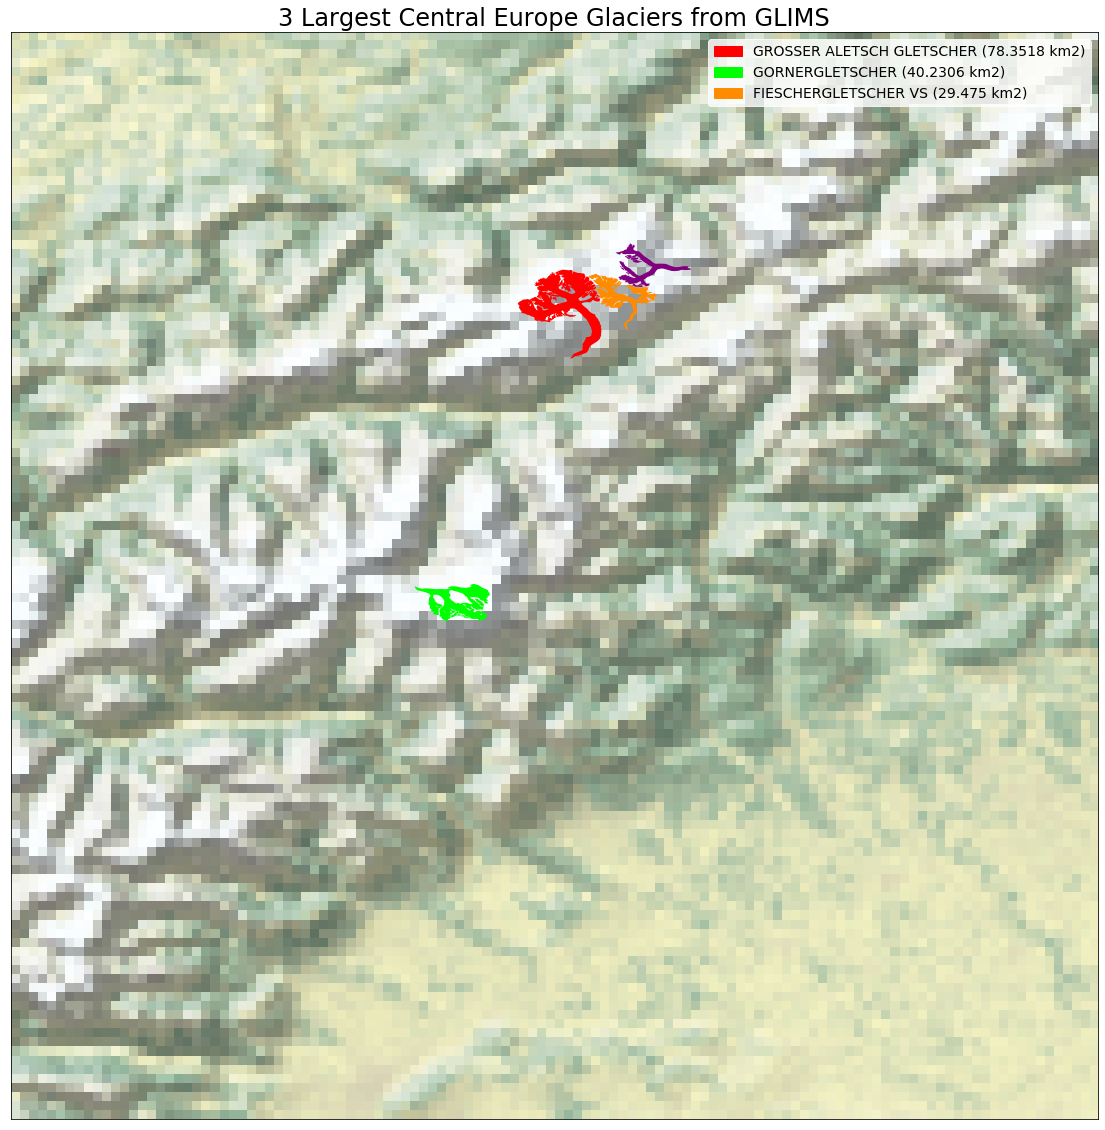

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
# Zoom
minx = 7
miny = 45
maxx = 9
maxy = 47
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
glims_glaciers_df.iloc[3:4].plot(ax=ax, color='purple')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Plot RGI Glaciers

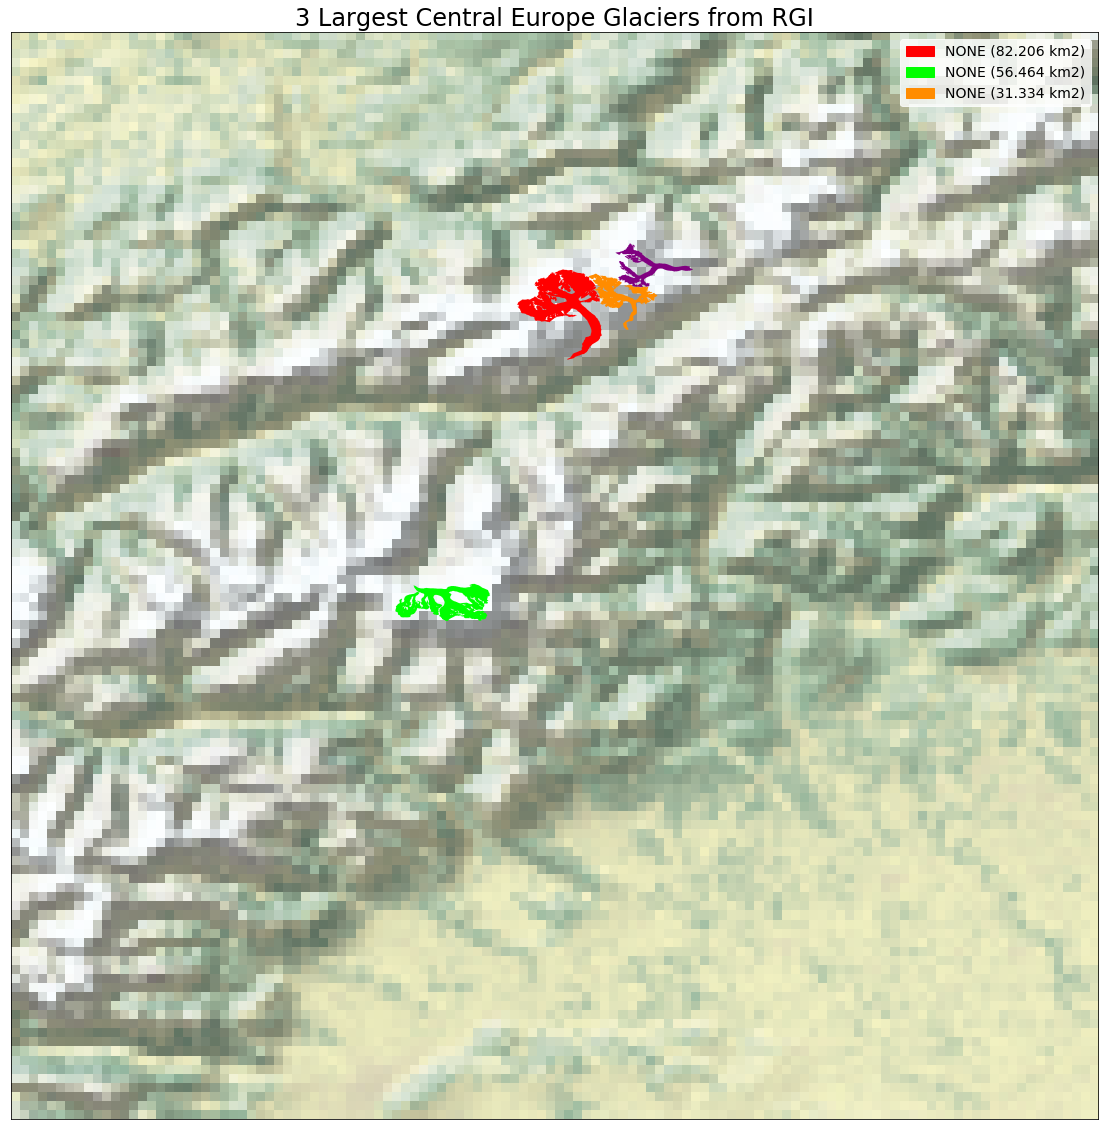

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
# Zoom
minx = 7
miny = 45
maxx = 9
maxy = 47
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
rgi_glaciers_df.iloc[4:5].plot(ax=ax, color='purple')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create final shapefiles
This section creates and formats the final dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

* The 1st one in both GLIMS and RGI is the Grosser Aletsch Glacier. GLIMS has the latest date so will go with that one.
* The 2nd one in both GLIMS and RGI is the Gorner Glacier. GLIMS has the latest date so will go with that one.
* The 3rd one in both GLIMS and RGI is the Fiescher Glacier. GLIMS has the latest date so will go with that one.


### Create final dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                        'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_data_df['reg_name'] = region_name

# Rename some columns
final_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop last 3 rows because they are the fourth and fifthe largest glaciers and we aren't interested in them
final_data_df.drop([3, 4, 5], inplace = True)

# Add RGI ID column
final_data_df['rgi_id'] = (rgi_glaciers_df['RGIId'][0], rgi_glaciers_df['RGIId'][1], rgi_glaciers_df['RGIId'][2])

# Add area_src column that gets filled lower down
final_data_df['area_src'] = '-999'

# Reorder the columns of the dataframe
final_data_df = final_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                               'area_km2', 'area_src', 'date', 'geometry']]

# Clean up the names of the glaciers
final_data_df.loc[0, 'glac_name'] = "Grosser Aletsch Glacier"
final_data_df.loc[1, 'glac_name'] = "Gorner Glacier"
final_data_df.loc[2, 'glac_name'] = "Fiescher Glacier"

In [17]:
final_data_df

,region_no,reg_name,glac_name,glims_id,rgi_id,area_km2,area_src,date,geometry
0,11,Central Europe,Grosser Aletsch Glacier,G008032E46504N,RGI60-11.01450,78.3518,-999,2009-09-15T00:00:00,"POLYGON Z ((8.018387000000001 46.562885 0, 8.0..."
1,11,Central Europe,Gorner Glacier,G007800E45965N,RGI60-11.02822,40.2306,-999,2009-09-15T00:00:00,"POLYGON Z ((7.877975 45.973549 0, 7.878131 45...."
2,11,Central Europe,Fiescher Glacier,G008144E46504N,RGI60-11.01478,29.4750,-999,2009-09-15T00:00:00,"POLYGON Z ((8.078189 46.554764 0, 8.0782120000..."


In [18]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x]
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    if glims_year == rgi_year:
        # Average GLIMS and RGI areas
        area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x]])
        area_src = 'A'
        print('Averaging area: ' + str(area))
    elif glims_year > rgi_year:
        # Use GLIMS area for the area
        area = glims_glaciers_df['db_area'][x]
        area_src = 'G'
        print('Using GLIMS area: ' + str(area))
    elif rgi_year > glims_year:
        # Use RGI area for the area
        area = rgi_glaciers_df['Area'][x]
        area_src = 'R'
        print('Using RGI area: ' + str(area))
    else:
        print("Error. Area could not be calculated.")
    
    print('')
    # Set the area in the final dataframe
    final_data_df.iloc[x, final_data_df.columns.get_loc('area_km2')] = area
    final_data_df.iloc[x, final_data_df.columns.get_loc('area_src')] = area_src
    
    # Clean the date format in the final dataframe
    final_data_df.iloc[x, final_data_df.columns.get_loc('date')] = glims_glaciers_df['src_date'][x][0:10]

glims date: 20090915
rgi date: 20030799
Using GLIMS area: 78.3518

glims date: 20090915
rgi date: 20030799
Using GLIMS area: 40.2306

glims date: 20090915
rgi date: 20030799
Using GLIMS area: 29.475



In [19]:
# Find the centroid of the glacier and add the lat/lon to the dataframe
centroidseries_gl = final_data_df['geometry'].centroid
    
final_data_df['cenlat'] = [centroidseries_gl.geometry.y[0], centroidseries_gl.geometry.y[1], 
                           centroidseries_gl.geometry.y[2]]
final_data_df['cenlon'] = [centroidseries_gl.geometry.x[0], centroidseries_gl.geometry.x[1], 
                           centroidseries_gl.geometry.x[2]]

# Reorder the columns of the dataframe
final_data_df = final_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                                'area_km2', 'area_src', 'date', 'cenlat', 'cenlon', 'geometry']]

In [20]:
# Because only using the GLIMS data, set the RGI ID to N/A
final_data_df['rgi_id'] = 'N/A'

In [21]:
final_data_df

,region_no,reg_name,glac_name,glims_id,rgi_id,area_km2,area_src,date,cenlat,cenlon,geometry
0,11,Central Europe,Grosser Aletsch Glacier,G008032E46504N,N/A,78.3518,G,2009-09-15,46.503216,8.019628,"POLYGON Z ((8.018387000000001 46.562885 0, 8.0..."
1,11,Central Europe,Gorner Glacier,G007800E45965N,N/A,40.2306,G,2009-09-15,45.951344,7.824111,"POLYGON Z ((7.877975 45.973549 0, 7.878131 45...."
2,11,Central Europe,Fiescher Glacier,G008144E46504N,N/A,29.4750,G,2009-09-15,46.517202,8.121695,"POLYGON Z ((8.078189 46.554764 0, 8.0782120000..."


### Plot final dataframe to check accuracy

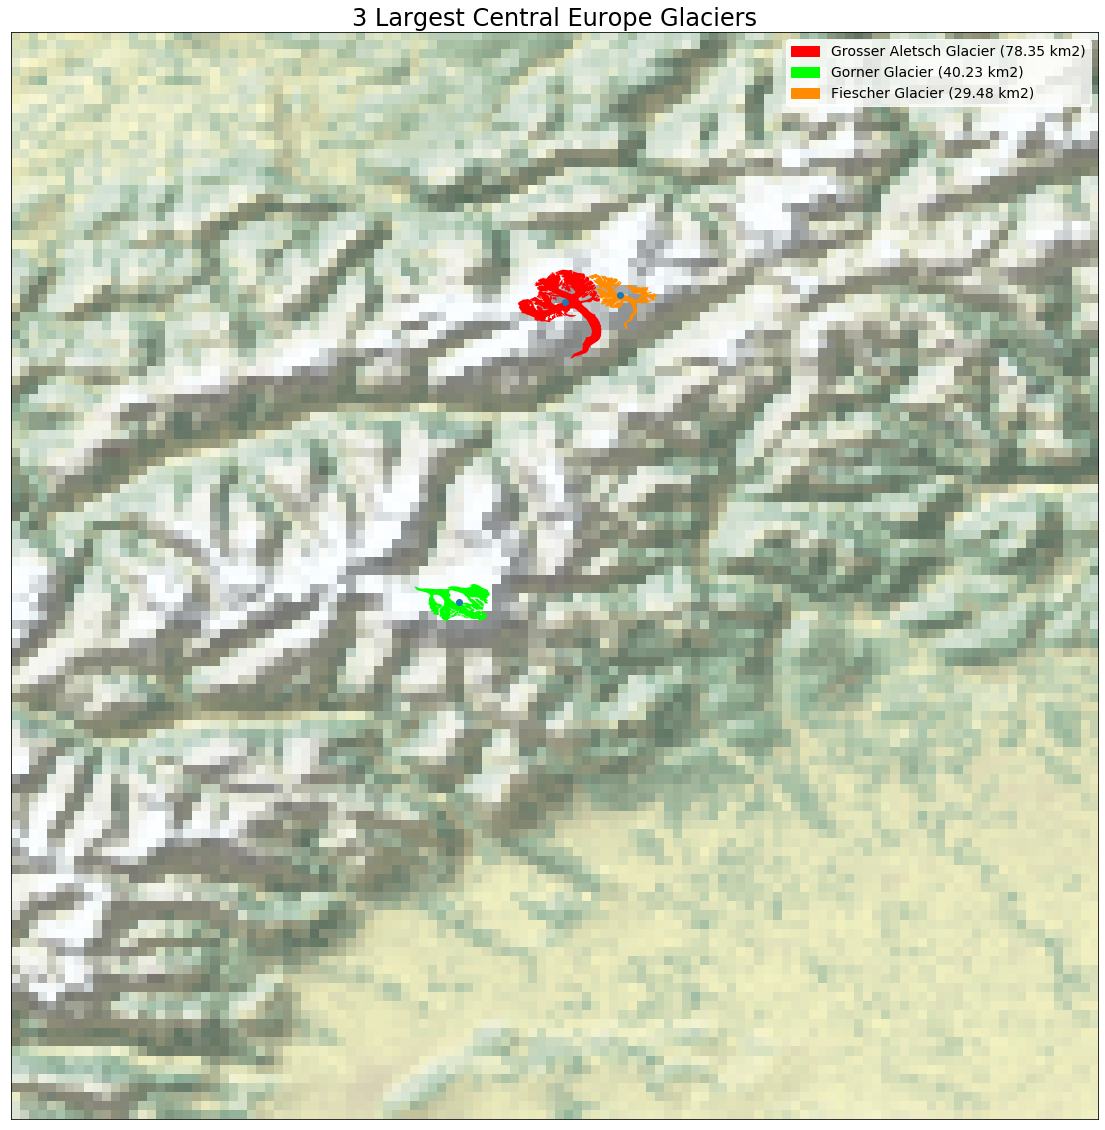

In [22]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_data_df['glac_name'][0] + ' (' + str(round(final_data_df['area_km2'][0], 2)) + ' km2)',
                 final_data_df['glac_name'][1] + ' (' + str(round(final_data_df['area_km2'][1], 2)) + ' km2)',
                 final_data_df['glac_name'][2] + ' (' + str(round(final_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
# Zoom
minx = 7
miny = 45
maxx = 9
maxy = 47
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_data_df.iloc[0:1].plot(ax=ax, color='red')
final_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)

# Plot the center points of the glacier complexes
centroidseries_gl.plot(ax=ax)

# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create shapefile from the final dataframe

In [23]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(zipfile_fn) == False:
    # Create the shapefile
    final_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_data_df.to_file(driver='ESRI Shapefile', filename=final_data_fn)
    
    # Zip up the shapefile
    zipfile_fn = ws.zipshp(final_data_fn, Delete=True)
    print("Creating zipfile: " + zipfile_fn)
else:
    print(zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-11-largest-glaciers.zip


# * * * * * * * * Ice Cap Analysis * * * * * * * *

In [24]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + region_number + "_laea.shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [25]:
ice_caps_ex_df

,id,area,geometry
0,51,213.932811,"POLYGON ((7.923965 46.414596, 7.92397745268424..."
1,9,112.923531,"POLYGON ((7.793124 45.908281, 7.79366 45.90807..."
2,28,46.692867,"POLYGON ((10.770959 46.820212, 10.77066 46.820..."
3,1220,39.163909,"POLYGON ((6.892190314696062 45.84328507631565,..."
4,18,38.374843,"POLYGON ((9.930299975480603 46.36974044957595,..."
5,43,35.035216,"(POLYGON ((12.745198 47.136491, 12.74510933445..."
6,12,33.532305,"POLYGON ((7.606441183017032 46.01672651735069,..."
7,4838,31.464246,"POLYGON ((8.416627 46.613217, 8.416762 46.6131..."
8,19,30.460078,"POLYGON ((10.57716 46.375216, 10.57716 46.3751..."
9,20,28.377574,"POLYGON ((7.782426 46.440848, 7.782314 46.4407..."


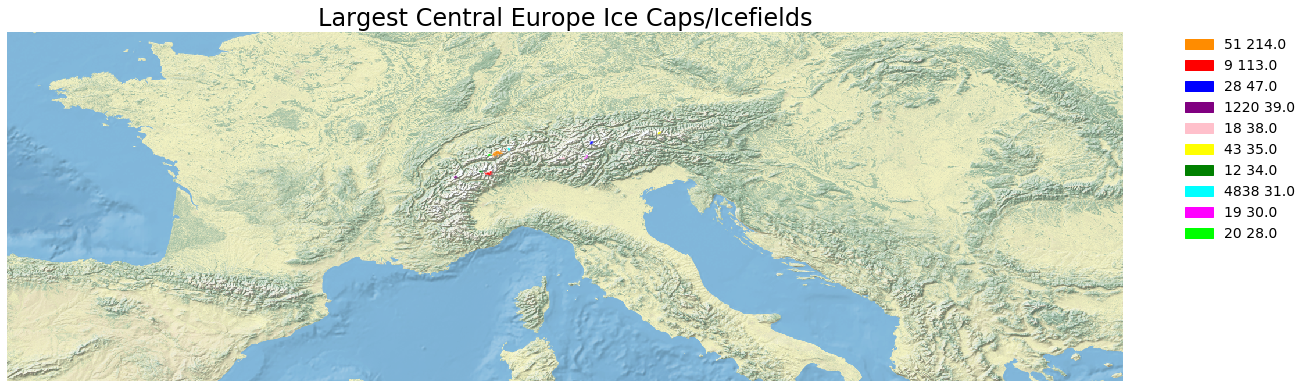

In [26]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = [str(ice_caps_ex_df['id'][0]) + ' ' + str(round(ice_caps_ex_df['area'][0])), 
                 str(ice_caps_ex_df['id'][1]) + ' ' + str(round(ice_caps_ex_df['area'][1])), 
                 str(ice_caps_ex_df['id'][2]) + ' ' + str(round(ice_caps_ex_df['area'][2])), 
                 str(ice_caps_ex_df['id'][3]) + ' ' + str(round(ice_caps_ex_df['area'][3])),
                 str(ice_caps_ex_df['id'][4]) + ' ' + str(round(ice_caps_ex_df['area'][4])),
                 str(ice_caps_ex_df['id'][5]) + ' ' + str(round(ice_caps_ex_df['area'][5])),
                 str(ice_caps_ex_df['id'][6]) + ' ' + str(round(ice_caps_ex_df['area'][6])),
                 str(ice_caps_ex_df['id'][7]) + ' ' + str(round(ice_caps_ex_df['area'][7])),
                 str(ice_caps_ex_df['id'][8]) + ' ' + str(round(ice_caps_ex_df['area'][8])),
                 str(ice_caps_ex_df['id'][9]) + ' ' + str(round(ice_caps_ex_df['area'][9]))]
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

## Create Final Ice Catchment Data Frame

This ice catchment data frame will then be saved to a shapefile.

In [27]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps/icefields
final_catchment_data_df.drop([3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add catchment names
final_catchment_data_df['ic_name'] = ['Grosser Aletsch Glacier Complex', 
                                      'Gorner Glacier Complex',
                                      'Gepatsch-Hintereis Glacier Complex'] 

### Get ice catchment GLIMS IDs and measurement dates from a range of glacier outline dates.

In [28]:
# Open GLIMS shapefile with all of the glacier outlines
glims_all_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_all_glaciers_fn)

In [29]:
# The call to the pip function can take a couple of minutes to many hours to run depending on the complexity and size
# of the ice catchment outline. I set up the code to save the output to shapefiles that can be read in more quickly
# if desired. However, you can toggle whether you read the files or run the pip command with the following variable.
# Note that you must run the pip command the first time this code is run in order to create the shapefiles.
run_code = 0 # set to 0 to read from saved shapefiles, set to 1 to run pip command and create shapefiles

# Get glaciers in the 1st largest glacier complex
if run_code == 1: # run pip command
    largest_ic_1_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True), 
                               buffer_val=.0001)
    largest_ic_1_glaciers = glims_all_glaciers_df.loc[largest_ic_1_mask]
    largest_ic_1_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_1_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-1st-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_1_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_1_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers = gpd.read_file(ic_1_glaciers_shape_fn)
    print("Reading file " + ic_1_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_1_min_date = largest_ic_1_glaciers['src_date'].min()[0:10]
largest_ic_1_max_date = largest_ic_1_glaciers['src_date'].max()[0:10]
print('1st largest start date: ' + largest_ic_1_min_date)
print('1st largest end date: ' + largest_ic_1_max_date)
print('')

# Get all glims ids that make up the 1st largest ice catchment
largest_ic_1_glims_ids = largest_ic_1_glaciers['glac_id']
for i in range(len(largest_ic_1_glims_ids)):
    if i == 0:
        all_largest_ic_1_ids = largest_ic_1_glims_ids[i]
    else:
        all_largest_ic_1_ids = all_largest_ic_1_ids + ', ' + largest_ic_1_glims_ids[i]

# Get glaciers in the 2nd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_2_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True), 
                               buffer_val=.0001)
    largest_ic_2_glaciers = glims_all_glaciers_df.loc[largest_ic_2_mask]
    largest_ic_2_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_2_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-2nd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_2_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_2_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers = gpd.read_file(ic_2_glaciers_shape_fn)
    print("Reading file " + ic_2_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_2_min_date = largest_ic_2_glaciers['src_date'].min()[0:10]
largest_ic_2_max_date = largest_ic_2_glaciers['src_date'].max()[0:10]
print('2nd largest start date: ' + largest_ic_2_min_date)
print('2nd largest end date: ' + largest_ic_2_max_date)
print('')

# Get all glims ids that make up the 2nd largest ice catchment
largest_ic_2_glims_ids = largest_ic_2_glaciers['glac_id']
for i in range(len(largest_ic_2_glims_ids)):
    if i == 0:
        all_largest_ic_2_ids = largest_ic_2_glims_ids[i]
    else:
        all_largest_ic_2_ids = all_largest_ic_2_ids + ', ' + largest_ic_2_glims_ids[i]


# Get glaciers in the 3rd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_3_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[2:3].reset_index(drop=True), 
                               buffer_val=.0001)
    largest_ic_3_glaciers = glims_all_glaciers_df.loc[largest_ic_3_mask]
    largest_ic_3_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_3_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-3rd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_3_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_3_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers = gpd.read_file(ic_3_glaciers_shape_fn)
    print("Reading file " + ic_3_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_3_min_date = largest_ic_3_glaciers['src_date'].min()[0:10]
largest_ic_3_max_date = largest_ic_3_glaciers['src_date'].max()[0:10]
print('3rd largest start date: ' + largest_ic_3_min_date)
print('3rd largest end date: ' + largest_ic_3_max_date)
print('')

# Get all glims ids that make up the 3rd largest ice catchment
largest_ic_3_glims_ids = largest_ic_3_glaciers['glac_id']
for i in range(len(largest_ic_3_glims_ids)):
    if i == 0:
        all_largest_ic_3_ids = largest_ic_3_glims_ids[i]
    else:
        all_largest_ic_3_ids = all_largest_ic_3_ids + ', ' + largest_ic_3_glims_ids[i]

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-11-1st-largest-ic-glacier-outlines.shp
1st largest start date: 1973-09-01
1st largest end date: 2009-09-15

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-11-2nd-largest-ic-glacier-outlines.shp
2nd largest start date: 1998-08-31
2nd largest end date: 2011-09-30

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-11-3rd-largest-ic-glacier-outlines.shp
3rd largest start date: 1969-06-30
3rd largest end date: 2015-08-26



In [30]:
# Find the centroid of the glacier complex and add the lat/lon to the dataframe
centroidseries = final_catchment_data_df['geometry'].centroid

In [31]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [largest_ic_1_min_date, largest_ic_2_min_date, largest_ic_3_min_date]

final_catchment_data_df['max_date'] = [largest_ic_1_max_date, largest_ic_2_max_date, largest_ic_3_max_date]

# Add lat/lon
final_catchment_data_df['cenlat'] = [centroidseries.geometry.y[0], centroidseries.geometry.y[1], 
                                     centroidseries.geometry.y[2]]
final_catchment_data_df['cenlon'] = [centroidseries.geometry.x[0], centroidseries.geometry.x[1], 
                                     centroidseries.geometry.x[2]]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'area', 
                                                   'min_date', 'max_date', 'cenlat', 'cenlon', 'geometry']]
# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [32]:
final_catchment_data_df

,region_no,reg_name,ic_name,area_km2,min_date,max_date,cenlat,cenlon,geometry
0,11,Central Europe,Grosser Aletsch Glacier Complex,213.932811,1973-09-01,2009-09-15,46.514546,8.052250,"POLYGON ((7.923965 46.414596, 7.92397745268424..."
1,11,Central Europe,Gorner Glacier Complex,112.923531,1998-08-31,2011-09-30,45.946925,7.809999,"POLYGON ((7.793124 45.908281, 7.79366 45.90807..."
2,11,Central Europe,Gepatsch-Hintereis Glacier Complex,46.692867,1969-06-30,2015-08-26,46.827877,10.752946,"POLYGON ((10.770959 46.820212, 10.77066 46.820..."


### Plot the final catchment dataframe to verify it looks correct

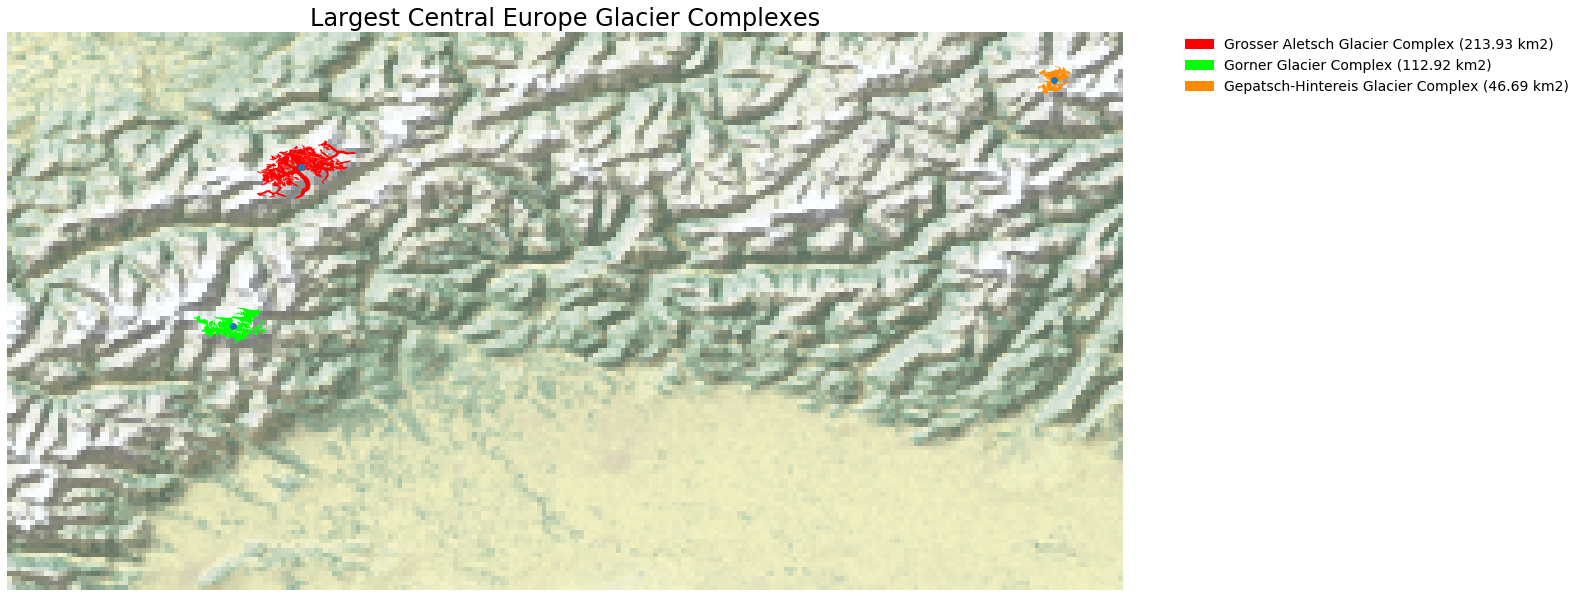

In [33]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['red', 'lime', 'darkorange'] #, 'purple', 'pink', 'yellow']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)'] 
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
# Zoom
minx = 7
miny = 45
maxx = 11
maxy = 47
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="red")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="lime")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="darkorange")
ax.set_title('Largest ' + region_name + ' Glacier Complexes', fontsize=24)
ax.set_axis_off()

# Plot the center points of the glacier complexes
centroidseries.plot(ax=ax)

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [34]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-11-largest-complexes.zip


In [35]:
# Save the glims ids to a text file because the text is too long to be saved to a shapefile
text_file_1st_fn = "data/final-dataset/region-" + region_number + "-1st-largest-glims-ids.txt"
if os.path.exists(text_file_1st_fn) == False:
    print("Creating text file: " + text_file_1st_fn)
    text_file = open(text_file_1st_fn, "w")
    n = text_file.write(all_largest_ic_1_ids)
    text_file.close()
else:
    print(text_file_1st_fn + " already extists")
    
text_file_2nd_fn = "data/final-dataset/region-" + region_number + "-2nd-largest-glims-ids.txt"
if os.path.exists(text_file_2nd_fn) == False:
    print("Creating text file: " + text_file_2nd_fn)
    text_file = open(text_file_2nd_fn, "w")
    n = text_file.write(all_largest_ic_2_ids)
    text_file.close()
else:
    print(text_file_2nd_fn + " already extists")
    
text_file_3rd_fn = "data/final-dataset/region-" + region_number + "-3rd-largest-glims-ids.txt"
if os.path.exists(text_file_3rd_fn) == False:
    print("Creating text file: " + text_file_3rd_fn)
    text_file = open(text_file_3rd_fn, "w")
    n = text_file.write(all_largest_ic_3_ids)
    text_file.close()
else:
    print(text_file_3rd_fn + " already extists")
    
# Save the glacier outline dataframes from the pip command to shapefiles for easier recall later because sometimes
# the pip command can take hours to run
ic_1_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-1st-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_1_glaciers_zfn) == False:
    # Create the shapefile
    ic_1_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers.to_file(driver='ESRI Shapefile', filename=ic_1_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_1_glaciers_zfn = ws.zipshp(ic_1_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_1_glaciers_zfn)
else:
    print(ic_1_glaciers_zfn + " already extists")
    
ic_2_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-2nd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_2_glaciers_zfn) == False:
    # Create the shapefile
    ic_2_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers.to_file(driver='ESRI Shapefile', filename=ic_2_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_2_glaciers_zfn = ws.zipshp(ic_2_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_2_glaciers_zfn)
else:
    print(ic_2_glaciers_zfn + " already extists")
    
ic_3_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-3rd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_3_glaciers_zfn) == False:
    # Create the shapefile
    ic_3_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers.to_file(driver='ESRI Shapefile', filename=ic_3_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_3_glaciers_zfn = ws.zipshp(ic_3_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_3_glaciers_zfn)
else:
    print(ic_3_glaciers_zfn + " already extists")

data/final-dataset/region-11-1st-largest-glims-ids.txt already extists
data/final-dataset/region-11-2nd-largest-glims-ids.txt already extists
data/final-dataset/region-11-3rd-largest-glims-ids.txt already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-11-1st-largest-ic-glacier-outlines.zip already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-11-2nd-largest-ic-glacier-outlines.zip already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-11-3rd-largest-ic-glacier-outlines.zip already extists


### Extra Stuff: Checking if pip function needs a buffer
Due to tiny differences in vertices computed from the explode method used to find ice catchments, the pip function doesn't always return all glaceris that should be in that outline. This section analyses what size buffer is needed to capture all glacier outlines that reside in an ice catchment outline.

A buffer value of .0001 was optimal for all three ice catchments. The buffer value was added to the pip call in the code above.

Even after the correct buffer is found, the area from the sum of all the glacier outlines in an ice catchment versus the area calculated from the exploded ice catchment didn't exactly match - the area from the sum is larger. This is due to an issue in the orginal GLIMS database where some glacier outlines are included twice but get different glacier ids so they appear to be different outlines even when they are not. So when the sum is calculated those glaciers are getting counted twice. Verified this by using a script written by Bruce Raup called find_overlapping_entities.py.

In [36]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

Stopping notebook.


#### Check 1st largest

In [ ]:
fig, ax1 = plt.subplots(figsize=(25, 25))
fig, ax2 = plt.subplots(figsize=(25, 25))

# Plot the catchment outline
final_catchment_data_df.iloc[0:1].boundary.plot(ax=ax1, color="blue")

# Plot the outlines acquired from pip function
largest_ic_1_glaciers.boundary.plot(ax=ax2, color="red")

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
print('Area from sum: ', largest_ic_1_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_1 = final_catchment_data_df['area_km2'].iloc[0:1][0] - largest_ic_1_glaciers['db_area'].sum()
if (abs(area_diff_1)) <= .001:
    print("Areas match well! Area difference: ", abs(area_diff_1))
    match1 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_1))
    match1 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = .0001
if match1 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_1_explode_outline = ice_caps_ex_df.iloc[0:1].reset_index(drop=True)
    largest_ic_1_mask_test = glims_all_glaciers_df.buffer(0).within(ic_1_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_1_glaciers_test = glims_all_glaciers_df.loc[largest_ic_1_mask_test]
    largest_ic_1_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    fig, ax1 = plt.subplots(figsize=(25, 25))
    fig, ax2 = plt.subplots(figsize=(25, 25))
    final_catchment_data_df.iloc[0:1].boundary.plot(ax=ax1, color='blue')
    largest_ic_1_glaciers_test.boundary.plot(ax=ax2, color='red')
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
    print('Area from sum: ', largest_ic_1_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(25, 25))
    largest_ic_1_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[0:1].boundary.plot(ax=ax, color='blue')

In [ ]:
# Check overlapping
input_overlap_file = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/" + \
                     "region-11-1st-largest-ic-glacier-outlines.shp"
overlap_out_file = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/overlap_files.shp"
args = {'infile': input_overlap_file, 'outfile': overlap_out_file, 'both': False, 'thresh': 0.0297, 'use_min': True}
myoverlaps = foe.find_overlaps_in_file(args)

In [ ]:
overlap_ids = []
for i in range(len(myoverlaps)):
    overlap_ids.append(myoverlaps[i]['properties']['glac_id'])

In [ ]:
# check that there are no duplicate glac ids
len(overlap_ids) != len(set(overlap_ids))

In [ ]:
# Remove overlapping glacier outlines
largest_ic_1_glaciers_test_clean = largest_ic_1_glaciers_test[~largest_ic_1_glaciers_test['glac_id'].isin(overlap_ids)]

# Compute the area
largest_ic_1_glaciers_test_clean['db_area'].sum()

In [ ]:
# Plot the new buffered glacier outlines against the ice catchment outline
fig, ax = plt.subplots(figsize=(25, 25))
largest_ic_1_glaciers_test_clean.boundary.plot(ax=ax, color='red')
final_catchment_data_df.iloc[0:1].boundary.plot(ax=ax, color='blue')

#### Check 2nd largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[1:2].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_2_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
print('Area from sum: ', largest_ic_2_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_2 = final_catchment_data_df['area_km2'].iloc[1:2][1] - largest_ic_2_glaciers['db_area'].sum()
if (abs(area_diff_2)) <= .001:
    print("Areas match well! Area difference: ", abs(area_diff_2))
    match2 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_2))
    match2 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = .0001
if match2 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_2_explode_outline = ice_caps_ex_df.iloc[1:2].reset_index(drop=True)
    largest_ic_2_mask_test = glims_all_glaciers_df.buffer(0).within(ic_2_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_2_glaciers_test = glims_all_glaciers_df.loc[largest_ic_2_mask_test]
    largest_ic_2_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_2_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    #acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
    print('Area from sum: ', largest_ic_2_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_2_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[1:2].boundary.plot(ax=ax, color='blue')

#### Check 3rd largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[2:3].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_3_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines 
# acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
print('Area from sum: ', largest_ic_3_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_3 = final_catchment_data_df['area_km2'].iloc[2:3][2] - largest_ic_3_glaciers['db_area'].sum()
if (abs(area_diff_3)) <= .001:
    print("Areas match well! Area difference: ", abs(area_diff_3))
    match3 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_3))
    match3 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = .0001
if match3 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_3_explode_outline = ice_caps_ex_df.iloc[2:3].reset_index(drop=True)
    largest_ic_3_mask_test = glims_all_glaciers_df.buffer(0).within(ic_3_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_3_glaciers_test = glims_all_glaciers_df.loc[largest_ic_3_mask_test]
    largest_ic_3_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_3_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
    print('Area from sum: ', largest_ic_3_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_3_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[2:3].boundary.plot(ax=ax, color='blue')